In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bolg4rin/simpson-dataset-fixed")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Пк\.cache\kagglehub\datasets\bolg4rin\simpson-dataset-fixed\versions\3


In [2]:
import os
from tqdm import tqdm
from torchvision.models import resnet50
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from random import shuffle
import PIL
from torchvision.transforms.functional import pil_to_tensor
import torchvision.transforms as transforms
import torchvision
from torch.optim.lr_scheduler import StepLR
dr = 'C:/Users/Пк/.cache/kagglehub/datasets/bolg4rin/simpson-dataset-fixed/versions/3/the_simpson_dataset/train/'

In [3]:
riba = resnet50(weights = 'ResNet50_Weights.DEFAULT')
riba.fc = nn.Linear(2048,42)
#riba = torch.nn.DataParallel(riba)
riba = riba.cuda()
loss_function = nn.CrossEntropyLoss().cuda()
optim = torch.optim.Adam(riba.parameters(),lr=0.0001)
scheduler = StepLR(optim, step_size=4, gamma=0.1)

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.25,scale=(0.05, 0.15), ratio=(1, 1),value='random'),
    transforms.Normalize(0.5, 0.5)
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
]
)

In [5]:
train_dataset = torchvision.datasets.ImageFolder(
    root='C:/Users/Пк/.cache/kagglehub/datasets/bolg4rin/simpson-dataset-fixed/versions/3/the_simpson_dataset/train', 
    transform=None
)
train_subset, validation_subset = torch.utils.data.random_split(train_dataset,[0.8,0.2])
train_subset.dataset.transform = train_transform
validation_subset.dataset.transform = val_transform

In [6]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_subset, batch_size=64, shuffle=False, num_workers=2)

In [7]:
from sklearn.metrics import f1_score
loss_graph = []
f1_graph = []
val_loss_graph = []

for epoch in range(10):
    running_loss = 0
    riba.train()
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optim.zero_grad()
    
        outputs = riba(inputs)
        loss = loss_function(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optim.step()
        
    accuracy = 0
    validation_loss = 0
    torch.save(riba.state_dict(),f'simpsons_model/simpsons_scheduler{epoch}.pth')
    riba.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = riba(inputs)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item()
            preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    macro_f1 = f1_score(targets, preds, average='macro')
    running_loss /= len(train_loader)
    validation_loss /= len(validation_loader)
    print('epoch',epoch,'loss',running_loss,'validation loss',validation_loss,f'validation F1 {(macro_f1*100):.2f}')
    loss_graph.append(running_loss)
    f1_graph.append(macro_f1)
    val_loss_graph.append(validation_loss)
    scheduler.step()
            

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:43<00:00,  1.27it/s]


epoch 0 loss 1.4425033046544053 validation loss 0.3656353027080045 validation F1 50.41


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:34<00:00,  1.39it/s]


epoch 1 loss 0.21394205170164582 validation loss 0.16615550349833388 validation F1 85.38


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:34<00:00,  1.38it/s]


epoch 2 loss 0.05284525318967022 validation loss 0.12579985033494956 validation F1 92.99


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:34<00:00,  1.38it/s]


epoch 3 loss 0.01787676041561911 validation loss 0.11190682071769102 validation F1 94.23


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:34<00:00,  1.39it/s]


epoch 4 loss 0.007449612585749506 validation loss 0.10491005043414506 validation F1 94.35


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:34<00:00,  1.39it/s]


epoch 5 loss 0.006385126088937844 validation loss 0.10270284193878372 validation F1 95.04


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:34<00:00,  1.39it/s]


epoch 6 loss 0.0055126061606156915 validation loss 0.10215413293123922 validation F1 94.91


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:35<00:00,  1.37it/s]


epoch 7 loss 0.00506383960956409 validation loss 0.10200329463590276 validation F1 94.87


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:34<00:00,  1.39it/s]


epoch 8 loss 0.004480794576913801 validation loss 0.10098861033717792 validation F1 95.33


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:35<00:00,  1.37it/s]


epoch 9 loss 0.00449000529541442 validation loss 0.10111239139752631 validation F1 94.85


In [8]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
test_dataset = torchvision.datasets.ImageFolder(
    root='C:/Users/Пк/.cache/kagglehub/datasets/bolg4rin/simpson-dataset-fixed/versions/3/the_simpson_dataset/test', 
    transform=val_transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
preds = []
targets = []
class_preds = []
class_targets = []
for i in range(42):
    class_preds.append([])
    class_targets.append([])
riba.eval()
with torch.no_grad():
    for inputs, target in tqdm(test_loader):
        inputs = inputs.cuda()
        target = target.cuda()
        outputs = riba(inputs)
        pred = torch.argmax(outputs, dim=1)
        for i in range (len(target)):
            class_code = target[i]
            class_targets[class_code].append(class_code.cpu().numpy())
            class_preds[class_code].append(pred[i].cpu().numpy())
        preds.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())
macro_f1 = f1_score(targets, preds, average='macro')
accuracy = accuracy_score(targets,preds)
print(f'Macro F1: {(macro_f1*100):.2f}%')
print(f'Accuracy: {(accuracy*100):.2f}%')
for i in range(len(class_preds)):
    acc = accuracy_score(class_preds[i],class_targets[i])
    print(f'{test_dataset.classes[i]} accuracy: {(acc*100):.2f}%')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.02s/it]

Macro F1: 87.30%
Accuracy: 87.73%
abraham_grampa_simpson accuracy: 100.00%
agnes_skinner accuracy: 50.00%
apu_nahasapeemapetilon accuracy: 100.00%
barney_gumble accuracy: 70.00%
bart_simpson accuracy: 100.00%
carl_carlson accuracy: 100.00%
charles_montgomery_burns accuracy: 100.00%
chief_wiggum accuracy: 100.00%
cletus_spuckler accuracy: 50.00%
comic_book_guy accuracy: 100.00%
disco_stu accuracy: 80.00%
edna_krabappel accuracy: 90.91%
fat_tony accuracy: 90.00%
gil accuracy: 70.00%
groundskeeper_willie accuracy: 80.00%
homer_simpson accuracy: 100.00%
kent_brockman accuracy: 100.00%
krusty_the_clown accuracy: 100.00%
lenny_leonard accuracy: 90.91%
lionel_hutz accuracy: 90.00%
lisa_simpson accuracy: 100.00%
maggie_simpson accuracy: 70.00%
marge_simpson accuracy: 90.91%
martin_prince accuracy: 80.00%
mayor_quimby accuracy: 90.91%
milhouse_van_houten accuracy: 100.00%
miss_hoover accuracy: 80.00%
moe_szyslak accuracy: 100.00%
ned_flanders accuracy: 100.00%
nelson_muntz accuracy: 100.00%
ott

Text(0, 0.5, 'Loss')

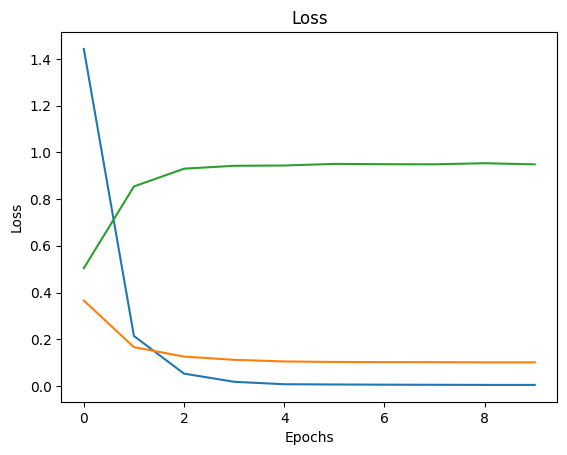

In [15]:
plt.figure()
plt.plot(loss_graph)
plt.plot(val_loss_graph)
plt.plot(f1_graph)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

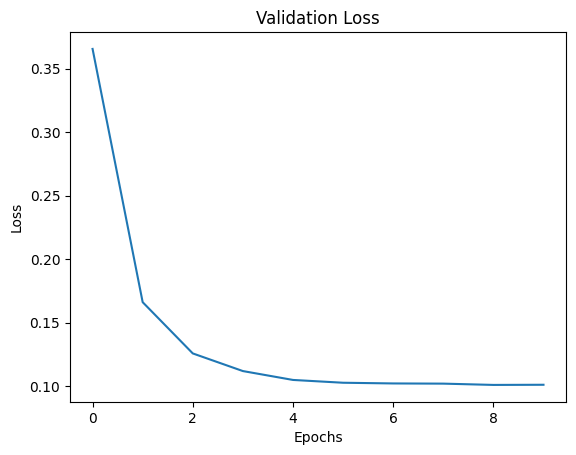

In [10]:
plt.figure()
plt.plot(val_loss_graph)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'F1 score')

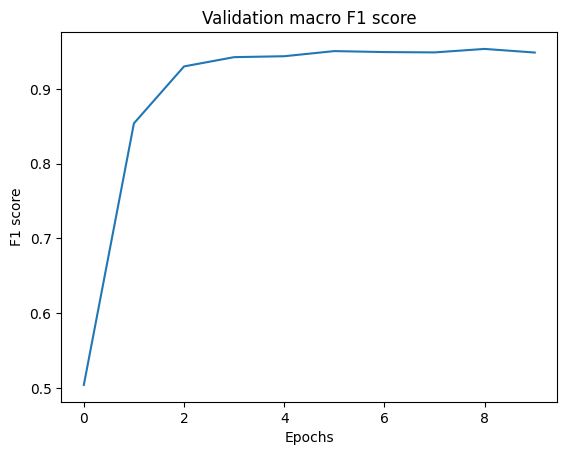

In [11]:
plt.figure()
plt.plot(f1_graph)
plt.title('Validation macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')